In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy

# Preparation and Scrapping of Data

In [2]:
# Load the data  from the first project into a dataframe.
df = pd.read_csv("FinalProject1.csv")

# Display the first 5 rows and inspect.
df.head()


Country/Territory Code                         Region  Year  \
0       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2000   
1       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2001   
2       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2002   
3       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2003   
4       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2004   

   (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                         1291                        53919   
1                                         1300                        54642   
2                                         1311                        54213   
3                                         1326                        54274   
4                                         1344                        54438   

   (c) Chronic Kidney Disease  (c) Chronic Respiratory Diseases  \
0                        4182                              7471   
1                        4251                              7565   
2                        4239                              7455   
3                        4336                              7471   
4                        4413                              7477   

   (c) Cirrhosis and Other Chronic Liver Diseases  (c) Diabetes Mellitus  ...  \
0                                            3249                   2515  ...   
1                                            3267                   2657  ...   
2                                            3238                   2745  ...   
3                                            3342                   2865  ...   
4                                            3394                   2986  ...   

   (o) Drug Use Disorders  (o) Fire, Heat, and Hot Substances  \
0                     186                                 465   
1                     197                                 467   
2                     202                                 455   
3                     216                                 499   
4                     229                                 516   

   (o) Forces of Nature  (o) Interpersonal Violence  (o) Neonatal Disorders  \
0                    52                        2871                   22920   
1                   384                        2971                   23276   
2                  1339                        3277                   23976   
3                   192                        3458                   24628   
4                    75                        3479                   24780   

   (o) Nutritional Deficiencies  (o) Poisonings  \
0                          3060             499   
1                          2973             502   
2                          2795             490   
3                          3039             531   
4                          3033             547   

   (o) Protein-Energy Malnutrition  (o) Road Injuries  (o) Self-harm  
0                             3013               6581           1137  
1                             2924               6720           1183  
2                             2746               6696           1190  
3                             2984               7243           1235  
4                             2978               7522           1283  

[5 rows x 34 columns]

In [3]:
# scrapping required data from the internet, scrapped data contains the average of PM2.5 particales in the air of each country,
# the data spans from 2018 to 2022, which means only 2018 & 2019 can be used with our data, 
# the average recommended of PM2.5 should be 5 by the WHO.
url="https://en.wikipedia.org/wiki/List_of_countries_by_air_pollution"

# putting the data from the url into a dataframe.
table=pd.read_html(url)
f=table[0]
f.head()

Rank Country/Region  2022  2021  2020  2019  2018  Population
0     1           Chad  89.7  75.9    --    --    --    17179740
1     2           Iraq  80.1  49.7    --  39.6    --    43533592
2     3       Pakistan  70.9  66.8    59  65.8  74.3   231402117
3     4        Bahrain  66.6  49.8  39.7  46.8  59.8     1463265
4     5     Bangladesh  65.8  76.9  77.1  83.3  97.1   169356251

In [4]:
f.shape #checking the data shape.

(131, 8)

In [5]:
f.isnull().sum() #checking for nulls, weirdly '-' isnt considered null.

Rank              0
Country/Region    0
2022              0
2021              0
2020              0
2019              0
2018              0
Population        0
dtype: int64

In [6]:
f.dtypes #checking for the data types, the data types doesnt match, so we will needs to change them.

Rank                int64
Country/Region     object
2022              float64
2021               object
2020               object
2019               object
2018               object
Population          int64
dtype: object

In [7]:
# due to the fact '--' are considered string not nulls we will have to drop all of them and replace with nulls.
f.replace('--', np.nan, inplace=True)
# we pick the year columns.
years_columns = ['2022', '2021', '2020', '2019', '2018']
# Convert the years values to float datatypes.
f[years_columns] = f[years_columns].astype(float)

In [8]:
# we get the mean values into one column, for each country pollution rate over the last 5 years,
# to fill with the average of all the null years in the row.
f['Mean'] = f[['2022', '2021', '2020', '2019', '2018']].mean(axis=1, skipna=True)

# fill missing values with the mean of each row.
f.fillna(value={'2020': f['Mean'], '2019': f['Mean'], '2018': f['Mean']}, inplace=True)

# remove the mean column after we are finished.
f.drop('Mean', axis=1, inplace=True)

f.head()

Rank Country/Region  2022  2021       2020  2019       2018  Population
0     1           Chad  89.7  75.9  82.800000  82.8  82.800000    17179740
1     2           Iraq  80.1  49.7  56.466667  39.6  56.466667    43533592
2     3       Pakistan  70.9  66.8  59.000000  65.8  74.300000   231402117
3     4        Bahrain  66.6  49.8  39.700000  46.8  59.800000     1463265
4     5     Bangladesh  65.8  76.9  77.100000  83.3  97.100000   169356251

In [9]:
# drop the years that we dont have, as our data only spans from 2000-2019 and other data that we dont need which is considered,
# lost data such as the ranks and populations, as they dont contribute to discovering trends in the numbers and causes of death.
f.drop(['2020','2021','2022', 'Population', 'Rank'], axis = 1) 

v = ['Country/Region'] 
value = ['2018','2019']  

# Melt(rotate) the dataframe to match our old dataset, so it is easier to merge.
df_melt = pd.melt(f, id_vars = v, value_vars=value , var_name='Year', value_name='Pollution')
df_melt.head()


# groupby countries to rearrange the dataframe.
df2= df_melt.groupby('Country/Region').apply(lambda x: x.sort_values(by=['Year'])).reset_index(drop=True)
#change the column into an int instead of string.
df2['Year'] = df2['Year'].astype(int)

# rename the country column so it matches our dataset.
df2.rename(columns={'Country/Region': 'Country/Territory'}, inplace=True)
df2.head()

C:\Users\Moustafa\AppData\Local\Temp\ipykernel_18780\21966517.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2= df_melt.groupby('Country/Region').apply(lambda x: x.sort_values(by=['Year'])).reset_index(drop=True)


Country/Territory  Year  Pollution
0           Albania  2018  14.333333
1           Albania  2019  14.333333
2           Algeria  2018  19.800000
3           Algeria  2019  21.200000
4           Andorra  2018   6.700000

In [10]:
# merging the data with our dataset, choosing the method "left" to maintain the data from our old dataset with the nulls.
merged_df = pd.merge(df, df2, on=['Country/Territory','Year'], how='left') 
# the scrapped dataframe doesnt contain data for all years or countries so additional data will be required.
merged_df.head()

Country/Territory Code                         Region  Year  \
0       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2000   
1       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2001   
2       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2002   
3       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2003   
4       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2004   

   (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                         1291                        53919   
1                                         1300                        54642   
2                                         1311                        54213   
3                                         1326                        54274   
4                                         1344                        54438   

   (c) Chronic Kidney Disease  (c) Chronic Respiratory Diseases  \
0                        4182                              7471   
1                        4251                              7565   
2                        4239                              7455   
3                        4336                              7471   
4                        4413                              7477   

   (c) Cirrhosis and Other Chronic Liver Diseases  (c) Diabetes Mellitus  ...  \
0                                            3249                   2515  ...   
1                                            3267                   2657  ...   
2                                            3238                   2745  ...   
3                                            3342                   2865  ...   
4                                            3394                   2986  ...   

   (o) Fire, Heat, and Hot Substances  (o) Forces of Nature  \
0                                 465                    52   
1                                 467                   384   
2                                 455                  1339   
3                                 499                   192   
4                                 516                    75   

   (o) Interpersonal Violence  (o) Neonatal Disorders  \
0                        2871                   22920   
1                        2971                   23276   
2                        3277                   23976   
3                        3458                   24628   
4                        3479                   24780   

   (o) Nutritional Deficiencies  (o) Poisonings  \
0                          3060             499   
1                          2973             502   
2                          2795             490   
3                          3039             531   
4                          3033             547   

   (o) Protein-Energy Malnutrition  (o) Road Injuries  (o) Self-harm  \
0                             3013               6581           1137   
1                             2924               6720           1183   
2                             2746               6696           1190   
3                             2984               7243           1235   
4                             2978               7522           1283   

   Pollution  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 35 columns]

In [11]:
# loading data in from another dataset to fill the null countries and years pollution numbers.
ef = pd.read_csv("PM2.5 Global Air Pollution 2010-2017.csv")
ef.head()

Country Name Country Code       2010       2011       2012       2013  \
0  Afghanistan          AFG  65.245592  66.835727  66.023174  61.366745   
1       Angola          AGO  33.787247  33.104195  33.415495  34.663923   
2      Albania          ALB  21.277828  22.772537  20.578259  19.938517   
3      Andorra          AND  12.807197  13.273506  12.407053  11.813673   
4   Arab World          ARB  53.787001  52.652279  53.297270  54.053822   

        2014       2015       2016       2017  
0  59.010330  61.252656  56.287047  56.910808  
1  32.974025  32.729873  31.785389  32.388505  
2  18.883955  19.512540  18.189934  18.200603  
3  10.830418  11.462178  10.255834  10.307621  
4  52.583603  60.406813  58.764905  58.689259

In [12]:
# get all the unique countries and the total number of them, note that there are multiple countries that are either,
# named differently or we dont have data for their causes of deaths.
ef1 =ef['Country Name'].unique()
print(ef1)
ef1.shape

['Afghanistan' 'Angola' 'Albania' 'Andorra' 'Arab World'
 'United Arab Emirates' 'Argentina' 'Armenia' 'American Samoa'
 'Antigua and Barbuda' 'Australia' 'Austria' 'Azerbaijan' 'Burundi'
 'Belgium' 'Benin' 'Burkina Faso' 'Bangladesh' 'Bulgaria' 'Bahrain'
 'Bahamas, The' 'Bosnia and Herzegovina' 'Belarus' 'Belize' 'Bermuda'
 'Bolivia' 'Brazil' 'Barbados' 'Brunei Darussalam' 'Bhutan' 'Botswana'
 'Central African Republic' 'Canada' 'Central Europe and the Baltics'
 'Switzerland' 'Chile' 'China' "Cote d'Ivoire" 'Cameroon'
 'Congo, Dem. Rep.' 'Congo, Rep.' 'Colombia' 'Comoros' 'Cabo Verde'
 'Costa Rica' 'Caribbean small states' 'Cuba' 'Cyprus' 'Czech Republic'
 'Germany' 'Djibouti' 'Dominica' 'Denmark' 'Dominican Republic' 'Algeria'
 'East Asia & Pacific (excluding high income)'
 'Early-demographic dividend' 'East Asia & Pacific'
 'Europe & Central Asia (excluding high income)' 'Europe & Central Asia'
 'Ecuador' 'Egypt, Arab Rep.' 'Euro area' 'Eritrea' 'Spain' 'Estonia'
 'Ethiopia' 'Europe

(240,)

In [13]:
# Lists of old in the imported dataset and new country names from our old dataset, to make both match our old dataset, 
# this cannot be checked automatically using any verification method as,
# they are called completely different spelled or called such as;
# Palestine(our dataset) being called Gaza and West Bank(imported dataset)
old = ['Bahamas, The', 'Brunei Darussalam', 'Cabo Verde', 'Congo, Rep', 'Cook Islands', 'Czech Republic',
       'Congo, Dem. Rep.', 'Gambia, The', 'Micronesia, Fed. Sts', 'Monaco', 'Nauru', 'Niue', 'Korea, Rep.', 'Palau',
       'West Bank and Gaza', 'Kitts and Nevis', 'St. Luci', 'St. Vincent and the Grenadines', 'San Marino',
       'Timor-Leste', 'Virgin Islands (U.S.)', 'Venezuela, RB', 'Yemen, Rep.']

new = ['Bahamas', 'Brunei', 'Cape Verde', 'Congo', 'Cook Islands',
       'Czechia', 'Democratic Republic of Congo', 'Gambia', 'Micronesia',
       'Monaco', 'Nauru', 'Niue', 'North Korea', 'Palau', 'Palestine',
       'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines',
       'San Marino', 'Timor', 'United States Virgin Islands', 'Venezuela', 'Yemen']

# create a dictionary from old names to new names
map1 = dict(zip(old, new))

# Rreplace the old country names with new ones in the dataframe
ef['Country Name'] = ef['Country Name'].replace(map1)

In [14]:
# rename the country column so it matches our dataset.
ef.rename(columns={'Country Name': 'Country/Territory', 'Country Code': 'Code'}, inplace=True)
# *data loss* drop the country code as it useless as we already have the codes for the countries and avoid difference in codes. 
f = ef
f.head()

Country/Territory Code       2010       2011       2012       2013  \
0       Afghanistan  AFG  65.245592  66.835727  66.023174  61.366745   
1            Angola  AGO  33.787247  33.104195  33.415495  34.663923   
2           Albania  ALB  21.277828  22.772537  20.578259  19.938517   
3           Andorra  AND  12.807197  13.273506  12.407053  11.813673   
4        Arab World  ARB  53.787001  52.652279  53.297270  54.053822   

        2014       2015       2016       2017  
0  59.010330  61.252656  56.287047  56.910808  
1  32.974025  32.729873  31.785389  32.388505  
2  18.883955  19.512540  18.189934  18.200603  
3  10.830418  11.462178  10.255834  10.307621  
4  52.583603  60.406813  58.764905  58.689259

In [15]:
# rename the country column so it matches our dataset.
v2 = ['Country/Territory','Code'] 
values2 = ['2010','2011','2012','2013','2014','2015','2016','2017']  
f_melt = pd.melt(f, id_vars = v2, value_vars=values2 , var_name='Year', value_name='Pollution')
f_melt.head()


# groupby countries to rearrange the dataframe to match the others.
f2= f_melt.groupby('Country/Territory').apply(lambda x: x.sort_values(by=['Year'])).reset_index(drop=True)
f2.head()

C:\Users\Moustafa\AppData\Local\Temp\ipykernel_18780\2609089496.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  f2= f_melt.groupby('Country/Territory').apply(lambda x: x.sort_values(by=['Year'])).reset_index(drop=True)


Country/Territory Code  Year  Pollution
0       Afghanistan  AFG  2010  65.245592
1       Afghanistan  AFG  2011  66.835727
2       Afghanistan  AFG  2012  66.023174
3       Afghanistan  AFG  2013  61.366745
4       Afghanistan  AFG  2014  59.010330

In [16]:
#change the column into an int instead of string.
f2['Year'] = f2['Year'].astype(int)
# merging the data with our dataset, choosing the method "outer" to maintain the rows for left and right dataframes,
# so we can refill them with the average of pollution.
merged_df2 = pd.merge(merged_df, f2, on=['Country/Territory','Year','Code'], how='left')
merged_df2.head()

Country/Territory Code                         Region  Year  \
0       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2000   
1       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2001   
2       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2002   
3       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2003   
4       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2004   

   (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                         1291                        53919   
1                                         1300                        54642   
2                                         1311                        54213   
3                                         1326                        54274   
4                                         1344                        54438   

   (c) Chronic Kidney Disease  (c) Chronic Respiratory Diseases  \
0                        4182                              7471   
1                        4251                              7565   
2                        4239                              7455   
3                        4336                              7471   
4                        4413                              7477   

   (c) Cirrhosis and Other Chronic Liver Diseases  (c) Diabetes Mellitus  ...  \
0                                            3249                   2515  ...   
1                                            3267                   2657  ...   
2                                            3238                   2745  ...   
3                                            3342                   2865  ...   
4                                            3394                   2986  ...   

   (o) Forces of Nature  (o) Interpersonal Violence  (o) Neonatal Disorders  \
0                    52                        2871                   22920   
1                   384                        2971                   23276   
2                  1339                        3277                   23976   
3                   192                        3458                   24628   
4                    75                        3479                   24780   

   (o) Nutritional Deficiencies  (o) Poisonings  \
0                          3060             499   
1                          2973             502   
2                          2795             490   
3                          3039             531   
4                          3033             547   

   (o) Protein-Energy Malnutrition  (o) Road Injuries  (o) Self-harm  \
0                             3013               6581           1137   
1                             2924               6720           1183   
2                             2746               6696           1190   
3                             2984               7243           1235   
4                             2978               7522           1283   

   Pollution_x  Pollution_y  
0          NaN          NaN  
1          NaN          NaN  
2          NaN          NaN  
3          NaN          NaN  
4          NaN          NaN  

[5 rows x 36 columns]

In [17]:
# combining both Pollution columns into one to fill the nulls in each and dropping the old two columns.
merged_df2['Pollution'] = merged_df2['Pollution_x'].combine_first(merged_df2['Pollution_y'])
mdf2 = merged_df2.drop(['Pollution_x','Pollution_y'], axis =1 )
mdf2.head()

Country/Territory Code                         Region  Year  \
0       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2000   
1       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2001   
2       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2002   
3       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2003   
4       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2004   

   (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                         1291                        53919   
1                                         1300                        54642   
2                                         1311                        54213   
3                                         1326                        54274   
4                                         1344                        54438   

   (c) Chronic Kidney Disease  (c) Chronic Respiratory Diseases  \
0                        4182                              7471   
1                        4251                              7565   
2                        4239                              7455   
3                        4336                              7471   
4                        4413                              7477   

   (c) Cirrhosis and Other Chronic Liver Diseases  (c) Diabetes Mellitus  ...  \
0                                            3249                   2515  ...   
1                                            3267                   2657  ...   
2                                            3238                   2745  ...   
3                                            3342                   2865  ...   
4                                            3394                   2986  ...   

   (o) Fire, Heat, and Hot Substances  (o) Forces of Nature  \
0                                 465                    52   
1                                 467                   384   
2                                 455                  1339   
3                                 499                   192   
4                                 516                    75   

   (o) Interpersonal Violence  (o) Neonatal Disorders  \
0                        2871                   22920   
1                        2971                   23276   
2                        3277                   23976   
3                        3458                   24628   
4                        3479                   24780   

   (o) Nutritional Deficiencies  (o) Poisonings  \
0                          3060             499   
1                          2973             502   
2                          2795             490   
3                          3039             531   
4                          3033             547   

   (o) Protein-Energy Malnutrition  (o) Road Injuries  (o) Self-harm  \
0                             3013               6581           1137   
1                             2924               6720           1183   
2                             2746               6696           1190   
3                             2984               7243           1235   
4                             2978               7522           1283   

   Pollution  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 35 columns]

In [18]:
mdf2.isnull().sum() #checking for nulls, alot of nulls due ot the countries we dont have data for.

Country/Territory                                    0
Code                                                 0
Region                                               0
Year                                                 0
(c) Alzheimer's Disease and Other Dementias          0
(c) Cardiovascular Diseases                          0
(c) Chronic Kidney Disease                           0
(c) Chronic Respiratory Diseases                     0
(c) Cirrhosis and Other Chronic Liver Diseases       0
(c) Diabetes Mellitus                                0
(c) HIV/AIDS                                         0
(c) Neoplasms                                        0
(c) Parkinson's Disease                              0
(c) Tuberculosis                                     0
(n) Acute Hepatitis                                  0
(n) Diarrheal Diseases                               0
(n) Digestive Diseases                               0
(n) Lower Respiratory Infections                     0
(n) Malari

In [19]:
mdf2 = mdf2.dropna(subset=['Code']) 
#dropping all null codes countries as they are useless to use due to the lack of causes of deaths for them.

In [20]:
# Calculate the average pollution level for each country using the groupby method
# the transform function is used to get the mean pollution of each country.
avg_pollution = mdf2.groupby('Country/Territory')['Pollution'].transform('mean')

# fill the null values in the Pollution column with the calculated average pollution values for each country.
mdf2['Pollution'].fillna(avg_pollution, inplace=True)

# display the first 50 rows of the DataFrame to inspect the filled values and verify the changes to pollution column.
mdf2.head(50)

C:\Users\Moustafa\AppData\Local\Temp\ipykernel_18780\416966660.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mdf2['Pollution'].fillna(avg_pollution, inplace=True)


Country/Territory Code                               Region  Year  \
0        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2000   
1        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2001   
2        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2002   
3        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2003   
4        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2004   
5        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2005   
6        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2006   
7        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2007   
8        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2008   
9        Afghanistan  AFG        ASIA (EX. NEAR EAST)           2009   
10       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2010   
11       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2011   
12       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2012   
13       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2013   
14       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2014   
15       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2015   
16       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2016   
17       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2017   
18       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2018   
19       Afghanistan  AFG        ASIA (EX. NEAR EAST)           2019   
20           Albania  ALB  EASTERN EUROPE                       2000   
21           Albania  ALB  EASTERN EUROPE                       2001   
22           Albania  ALB  EASTERN EUROPE                       2002   
23           Albania  ALB  EASTERN EUROPE                       2003   
24           Albania  ALB  EASTERN EUROPE                       2004   
25           Albania  ALB  EASTERN EUROPE                       2005   
26           Albania  ALB  EASTERN EUROPE                       2006   
27           Albania  ALB  EASTERN EUROPE                       2007   
28           Albania  ALB  EASTERN EUROPE                       2008   
29           Albania  ALB  EASTERN EUROPE                       2009   
30           Albania  ALB  EASTERN EUROPE                       2010   
31           Albania  ALB  EASTERN EUROPE                       2011   
32           Albania  ALB  EASTERN EUROPE                       2012   
33           Albania  ALB  EASTERN EUROPE                       2013   
34           Albania  ALB  EASTERN EUROPE                       2014   
35           Albania  ALB  EASTERN EUROPE                       2015   
36           Albania  ALB  EASTERN EUROPE                       2016   
37           Albania  ALB  EASTERN EUROPE                       2017   
38           Albania  ALB  EASTERN EUROPE                       2018   
39           Albania  ALB  EASTERN EUROPE                       2019   
40           Algeria  DZA  NORTHERN AFRICA                      2000   
41           Algeria  DZA  NORTHERN AFRICA                      2001   
42           Algeria  DZA  NORTHERN AFRICA                      2002   
43           Algeria  DZA  NORTHERN AFRICA                      2003   
44           Algeria  DZA  NORTHERN AFRICA                      2004   
45           Algeria  DZA  NORTHERN AFRICA                      2005   
46           Algeria  DZA  NORTHERN AFRICA                      2006   
47           Algeria  DZA  NORTHERN AFRICA                      2007   
48           Algeria  DZA  NORTHERN AFRICA                      2008   
49           Algeria  DZA  NORTHERN AFRICA                      2009   

    (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                          1291                        53919   
1                                          1300                        54642   
2                                          1311                        54213   
3         

In [21]:
 mdf2.isnull().sum() #checking for nulls again

Country/Territory                                   0
Code                                                0
Region                                              0
Year                                                0
(c) Alzheimer's Disease and Other Dementias         0
(c) Cardiovascular Diseases                         0
(c) Chronic Kidney Disease                          0
(c) Chronic Respiratory Diseases                    0
(c) Cirrhosis and Other Chronic Liver Diseases      0
(c) Diabetes Mellitus                               0
(c) HIV/AIDS                                        0
(c) Neoplasms                                       0
(c) Parkinson's Disease                             0
(c) Tuberculosis                                    0
(n) Acute Hepatitis                                 0
(n) Diarrheal Diseases                              0
(n) Digestive Diseases                              0
(n) Lower Respiratory Infections                    0
(n) Malaria                 

In [22]:
#checking which countries has data loss in pollution for the countries that dont have data, they will have to be dropped.
null = mdf2[mdf2['Pollution'].isnull()]
null['Country/Territory'].unique()
mdf2=mdf2.dropna()
mdf2.head()

Country/Territory Code                         Region  Year  \
0       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2000   
1       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2001   
2       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2002   
3       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2003   
4       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2004   

   (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                         1291                        53919   
1                                         1300                        54642   
2                                         1311                        54213   
3                                         1326                        54274   
4                                         1344                        54438   

   (c) Chronic Kidney Disease  (c) Chronic Respiratory Diseases  \
0                        4182                              7471   
1                        4251                              7565   
2                        4239                              7455   
3                        4336                              7471   
4                        4413                              7477   

   (c) Cirrhosis and Other Chronic Liver Diseases  (c) Diabetes Mellitus  ...  \
0                                            3249                   2515  ...   
1                                            3267                   2657  ...   
2                                            3238                   2745  ...   
3                                            3342                   2865  ...   
4                                            3394                   2986  ...   

   (o) Fire, Heat, and Hot Substances  (o) Forces of Nature  \
0                                 465                    52   
1                                 467                   384   
2                                 455                  1339   
3                                 499                   192   
4                                 516                    75   

   (o) Interpersonal Violence  (o) Neonatal Disorders  \
0                        2871                   22920   
1                        2971                   23276   
2                        3277                   23976   
3                        3458                   24628   
4                        3479                   24780   

   (o) Nutritional Deficiencies  (o) Poisonings  \
0                          3060             499   
1                          2973             502   
2                          2795             490   
3                          3039             531   
4                          3033             547   

   (o) Protein-Energy Malnutrition  (o) Road Injuries  (o) Self-harm  \
0                             3013               6581           1137   
1                             2924               6720           1183   
2                             2746               6696           1190   
3                             2984               7243           1235   
4                             2978               7522           1283   

   Pollution  
0   61.61651  
1   61.61651  
2   61.61651  
3   61.61651  
4   61.61651  

[5 rows x 35 columns]

In [23]:
 mdf2.isnull().sum() # making sure no more nulls exist

Country/Territory                                 0
Code                                              0
Region                                            0
Year                                              0
(c) Alzheimer's Disease and Other Dementias       0
(c) Cardiovascular Diseases                       0
(c) Chronic Kidney Disease                        0
(c) Chronic Respiratory Diseases                  0
(c) Cirrhosis and Other Chronic Liver Diseases    0
(c) Diabetes Mellitus                             0
(c) HIV/AIDS                                      0
(c) Neoplasms                                     0
(c) Parkinson's Disease                           0
(c) Tuberculosis                                  0
(n) Acute Hepatitis                               0
(n) Diarrheal Diseases                            0
(n) Digestive Diseases                            0
(n) Lower Respiratory Infections                  0
(n) Malaria                                       0
(n) Maternal

# Visulization of Data

In [24]:
df = mdf2

In [25]:
df.to_csv("FinalProject2.csv", index=False)

In [26]:
df.head()

Country/Territory Code                         Region  Year  \
0       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2000   
1       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2001   
2       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2002   
3       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2003   
4       Afghanistan  AFG  ASIA (EX. NEAR EAST)           2004   

   (c) Alzheimer's Disease and Other Dementias  (c) Cardiovascular Diseases  \
0                                         1291                        53919   
1                                         1300                        54642   
2                                         1311                        54213   
3                                         1326                        54274   
4                                         1344                        54438   

   (c) Chronic Kidney Disease  (c) Chronic Respiratory Diseases  \
0                        4182                              7471   
1                        4251                              7565   
2                        4239                              7455   
3                        4336                              7471   
4                        4413                              7477   

   (c) Cirrhosis and Other Chronic Liver Diseases  (c) Diabetes Mellitus  ...  \
0                                            3249                   2515  ...   
1                                            3267                   2657  ...   
2                                            3238                   2745  ...   
3                                            3342                   2865  ...   
4                                            3394                   2986  ...   

   (o) Fire, Heat, and Hot Substances  (o) Forces of Nature  \
0                                 465                    52   
1                                 467                   384   
2                                 455                  1339   
3                                 499                   192   
4                                 516                    75   

   (o) Interpersonal Violence  (o) Neonatal Disorders  \
0                        2871                   22920   
1                        2971                   23276   
2                        3277                   23976   
3                        3458                   24628   
4                        3479                   24780   

   (o) Nutritional Deficiencies  (o) Poisonings  \
0                          3060             499   
1                          2973             502   
2                          2795             490   
3                          3039             531   
4                          3033             547   

   (o) Protein-Energy Malnutrition  (o) Road Injuries  (o) Self-harm  \
0                             3013               6581           1137   
1                             2924               6720           1183   
2                             2746               6696           1190   
3                             2984               7243           1235   
4                             2978               7522           1283   

   Pollution  
0   61.61651  
1   61.61651  
2   61.61651  
3   61.61651  
4   61.61651  

[5 rows x 35 columns]

# Question 1 and General Visualization for the relations

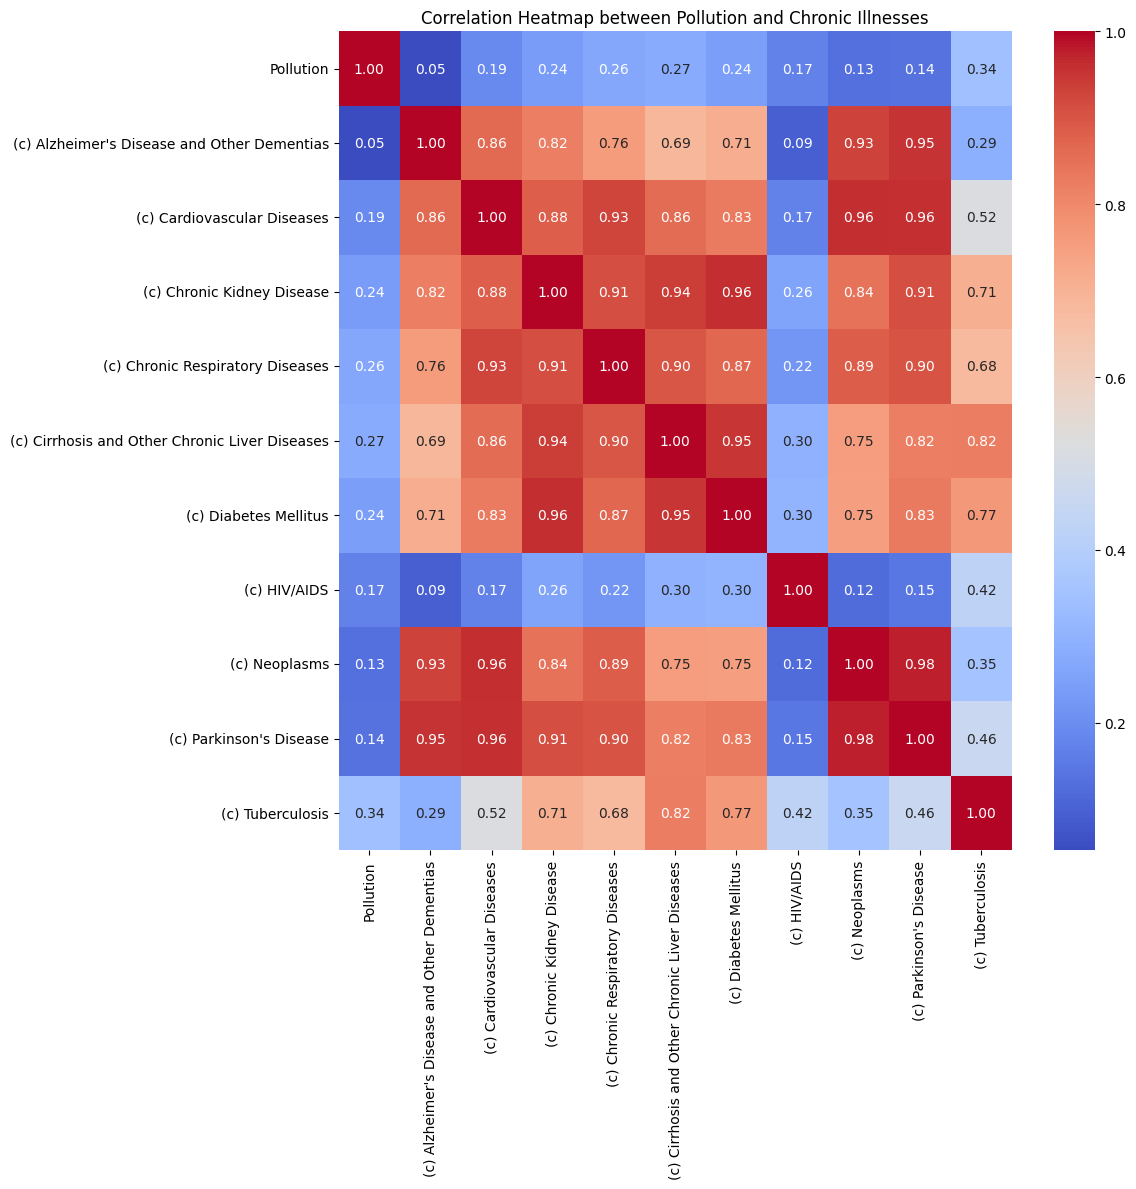

In [27]:
selected_columns = [
    'Pollution',  
    "(c) Alzheimer's Disease and Other Dementias",
    '(c) Cardiovascular Diseases', '(c) Chronic Kidney Disease',
    '(c) Chronic Respiratory Diseases',
    '(c) Cirrhosis and Other Chronic Liver Diseases',
    '(c) Diabetes Mellitus', '(c) HIV/AIDS', '(c) Neoplasms',
    "(c) Parkinson's Disease", '(c) Tuberculosis'
]

# Selecting the data
selected_data = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Pollution and Chronic Illnesses')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

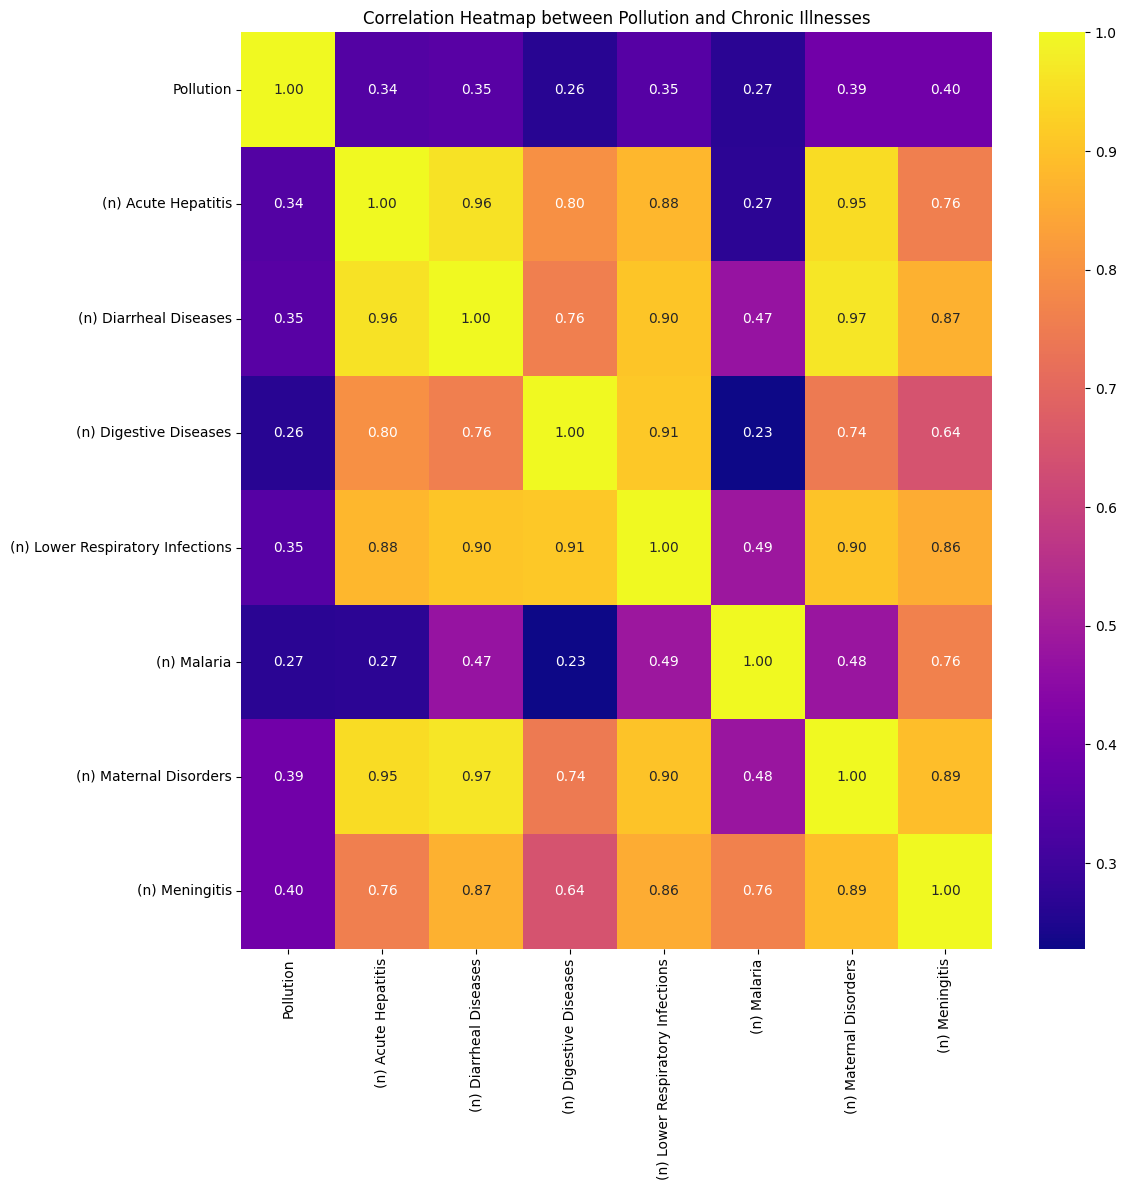

In [28]:
selected_columns = [
    'Pollution',  
'(n) Acute Hepatitis',                          
'(n) Diarrheal Diseases',                            
'(n) Digestive Diseases',
'(n) Lower Respiratory Infections', 
'(n) Malaria',
'(n) Maternal Disorders',
'(n) Meningitis'
]

# Selecting the data
selected_data = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt=".2f")
plt.title('Correlation Heatmap between Pollution and Chronic Illnesses')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

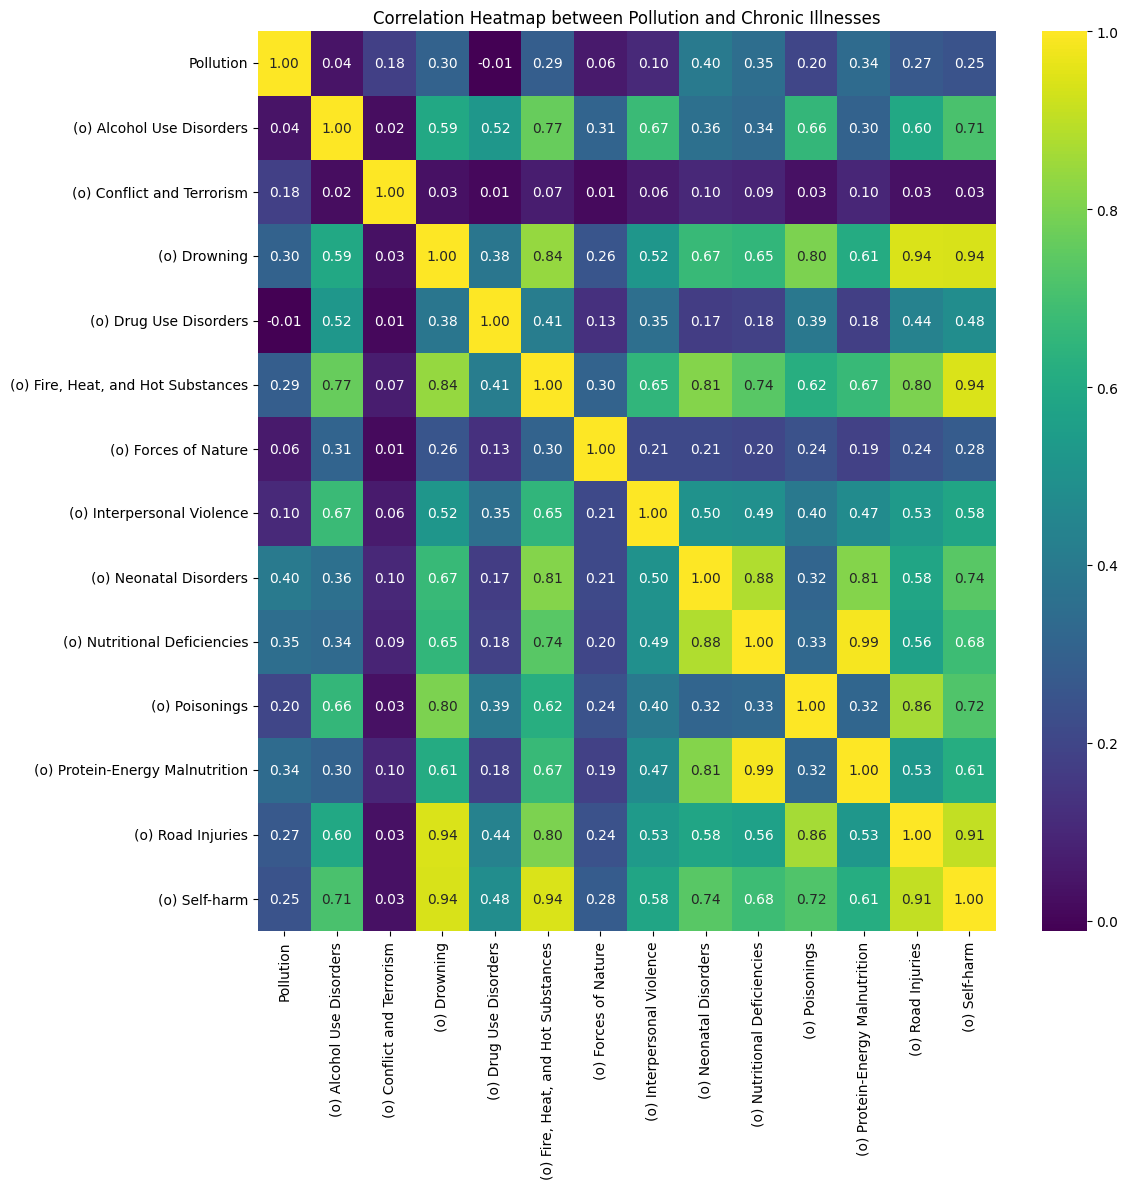

In [29]:
selected_columns = [
    'Pollution',  
    "(o) Alcohol Use Disorders",
    "(o) Conflict and Terrorism",
    "(o) Drowning",
    "(o) Drug Use Disorders",
    "(o) Fire, Heat, and Hot Substances",
    "(o) Forces of Nature",
    "(o) Interpersonal Violence",
    "(o) Neonatal Disorders",
    "(o) Nutritional Deficiencies",
    "(o) Poisonings",
    "(o) Protein-Energy Malnutrition",
    "(o) Road Injuries",
    "(o) Self-harm"
]


# Selecting the data
selected_data = df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap between Pollution and Chronic Illnesses')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

# Question 2

In [30]:
grouped_region =df
grouped_region['Region'] = grouped_region['Region'].str.replace(r'\s+', ' ', regex=True).str.strip().str.upper()

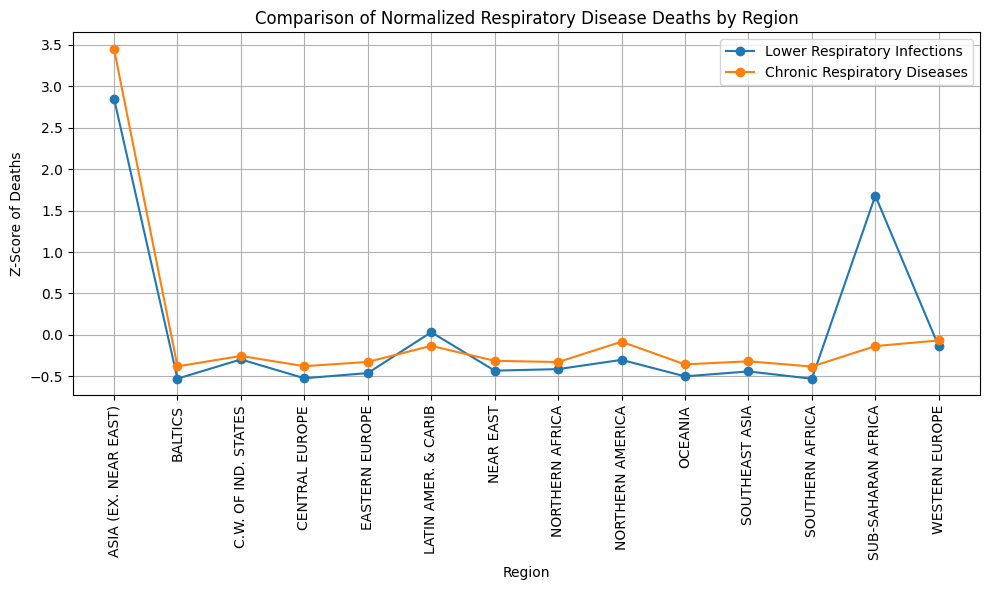

In [31]:
# Group by region and aggregate data
grouped_region = df.groupby('Region').agg({
    '(n) Lower Respiratory Infections': 'sum',
    '(c) Chronic Respiratory Diseases': 'sum',
})

# Calculate the mean and standard deviation for Z-score normalization
mean_lri = grouped_region['(n) Lower Respiratory Infections'].mean()
std_lri = grouped_region['(n) Lower Respiratory Infections'].std()
mean_crd = grouped_region['(c) Chronic Respiratory Diseases'].mean()
std_crd = grouped_region['(c) Chronic Respiratory Diseases'].std()

# Normalize the deaths using Z-score
grouped_region['LRI Deaths (Z)'] = (grouped_region['(n) Lower Respiratory Infections'] - mean_lri) / std_lri
grouped_region['CRD Deaths (Z)'] = (grouped_region['(c) Chronic Respiratory Diseases'] - mean_crd) / std_crd

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
grouped_region[['LRI Deaths (Z)', 'CRD Deaths (Z)']].plot(kind='line', marker='o', ax=ax)

ax.set_title('Comparison of Normalized Respiratory Disease Deaths by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Z-Score of Deaths')
ax.grid(True)
ax.legend(['Lower Respiratory Infections', 'Chronic Respiratory Diseases'])

plt.xticks(range(len(grouped_region.index)), grouped_region.index, rotation=90)
plt.tight_layout()
plt.show()

From the graph the common region is Asia with the highest number in both causes as a whole, with sub-saharan Africa having a spike in causes caused by Lower Respiratory Infections.

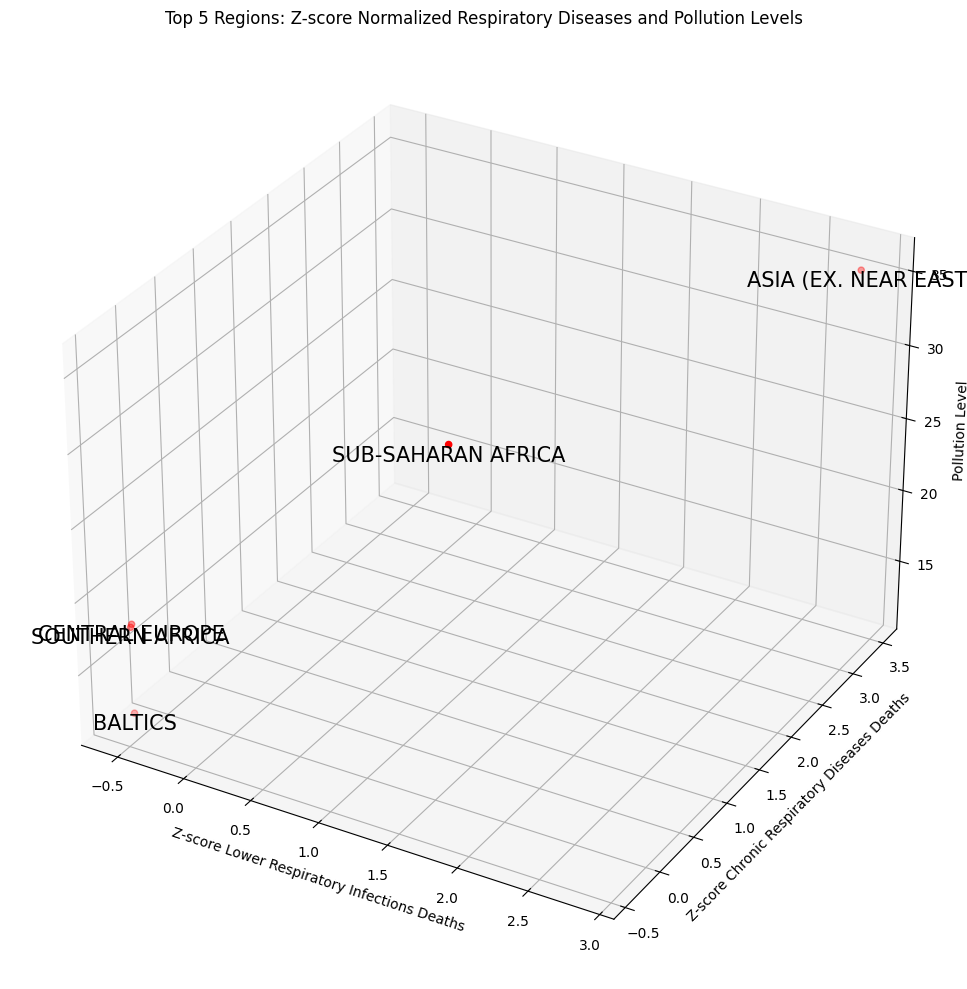

In [32]:
grouped_region = df.groupby('Region').agg({
    '(n) Lower Respiratory Infections': 'sum',
    '(c) Chronic Respiratory Diseases': 'sum',
    'Pollution': 'mean'
})

# Calculate mean and standard deviation for Z-score normalization
mean_lri = grouped_region['(n) Lower Respiratory Infections'].mean()
std_lri = grouped_region['(n) Lower Respiratory Infections'].std()
mean_crd = grouped_region['(c) Chronic Respiratory Diseases'].mean()
std_crd = grouped_region['(c) Chronic Respiratory Diseases'].std()

# Apply Z-score normalization
grouped_region['Z-score LRI Deaths'] = (grouped_region['(n) Lower Respiratory Infections'] - mean_lri) / std_lri
grouped_region['Z-score CRD Deaths'] = (grouped_region['(c) Chronic Respiratory Diseases'] - mean_crd) / std_crd

# Calculate a score to rank the regions for selecting the top 5
grouped_region['Total Z-score'] = abs(grouped_region['Z-score LRI Deaths']) + abs(grouped_region['Z-score CRD Deaths'])

# Selecting the top 5 regions based on the total Z-score
top_regions = grouped_region.nlargest(5, 'Total Z-score')

# Create a 3D scatter plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot data using Z-scores
x = top_regions['Z-score LRI Deaths']
y = top_regions['Z-score CRD Deaths']
z = top_regions['Pollution']
regions = top_regions.index

# Plotting the data with region labels
scatter = ax.scatter(x, y, z, c='r', marker='o')

# Labeling
ax.set_xlabel('Z-score Lower Respiratory Infections Deaths')
ax.set_ylabel('Z-score Chronic Respiratory Diseases Deaths')
ax.set_zlabel('Pollution Level')

# Setting the title
ax.set_title('Top 5 Regions: Z-score Normalized Respiratory Diseases and Pollution Levels')

# Adding region labels to points
for i, txt in enumerate(regions):
    ax.text(x.iloc[i], y.iloc[i], z.iloc[i], '%s' % (txt), size=15, ha='center', va='top')
    
plt.tight_layout()
plt.show()

On the other hand, this 3D scatter plot brought out a strong relation between pollution levels and respiratory disease death in all the regions(except the Baltics), considering that the average pollution of each region is above 5 and the recommended amount of PM2.5 is less than 5 by the WHO. The highest pollution levels which are present are linked with lower respiratory infections and chronic respiratory diseases are mostly in the Asia region and Sub-Saharan Africa region. This trend indicates that regions of high pollution also bear the greatest health burden from respiratory conditions, accentuating the potential health dividends of reduced environmental pollution. Moreover, the direct connection of the two respiratory disease types means that interventions directed against one may reap affirmative outcomes for the other. Integrated health approaches should take that into account.

# Question 3

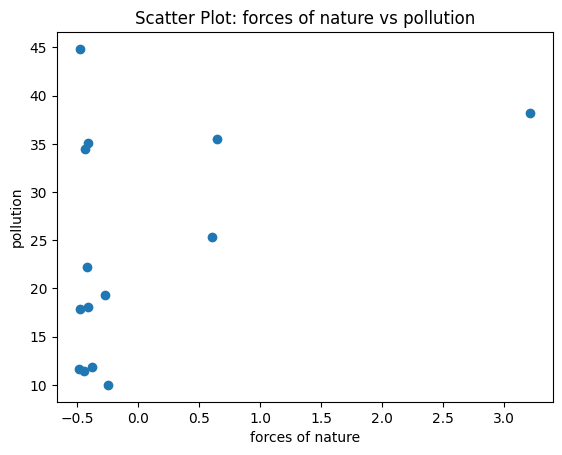

In [33]:
# Is there any direct correlation between pollution and number of deaths caused by forces of nature?

average_deaths = df.groupby('Region').agg({
    '(o) Forces of Nature': 'mean',
    'Pollution': 'mean'
}).reset_index()


# Copying data to avoid SettingWithCopyWarning when modifying
top_regions_normalized = average_deaths.copy()

# Calculate mean and standard deviation for Z-score normalization
mean_forces = top_regions_normalized['(o) Forces of Nature'].mean()
std_forces = top_regions_normalized['(o) Forces of Nature'].std()


# Apply Z-score normalization using .loc to ensure proper setting
top_regions_normalized.loc[:, '(o) Forces of Nature'] = (top_regions_normalized['(o) Forces of Nature'] - mean_forces) / std_forces

# Columns of interest for plotting
column1 = "forces of nature"
column2 = "pollution"

# Scatter plot
plt.scatter(top_regions_normalized['(o) Forces of Nature'], top_regions_normalized['Pollution'])
plt.xlabel(column1)
plt.ylabel(column2)
plt.title("Scatter Plot: " + column1 + " vs " + column2)
plt.show()

As shown above, data has been grouped by region. Then  a scatter plot used to obtain any correlation between forces of nature and pollution that indicates there is no relationship between 2  factors.  This relation is obtained by checking the highest pollution levels that exist in regions with little to no death numbers caused by forces of nature and in regions where there is a significant number of deaths by the same incident. However, that one region at the right of the scatter plot graph that has a high number of incidents by death and and pollution may indicate that there maybe a correlation that exists

# Question 4

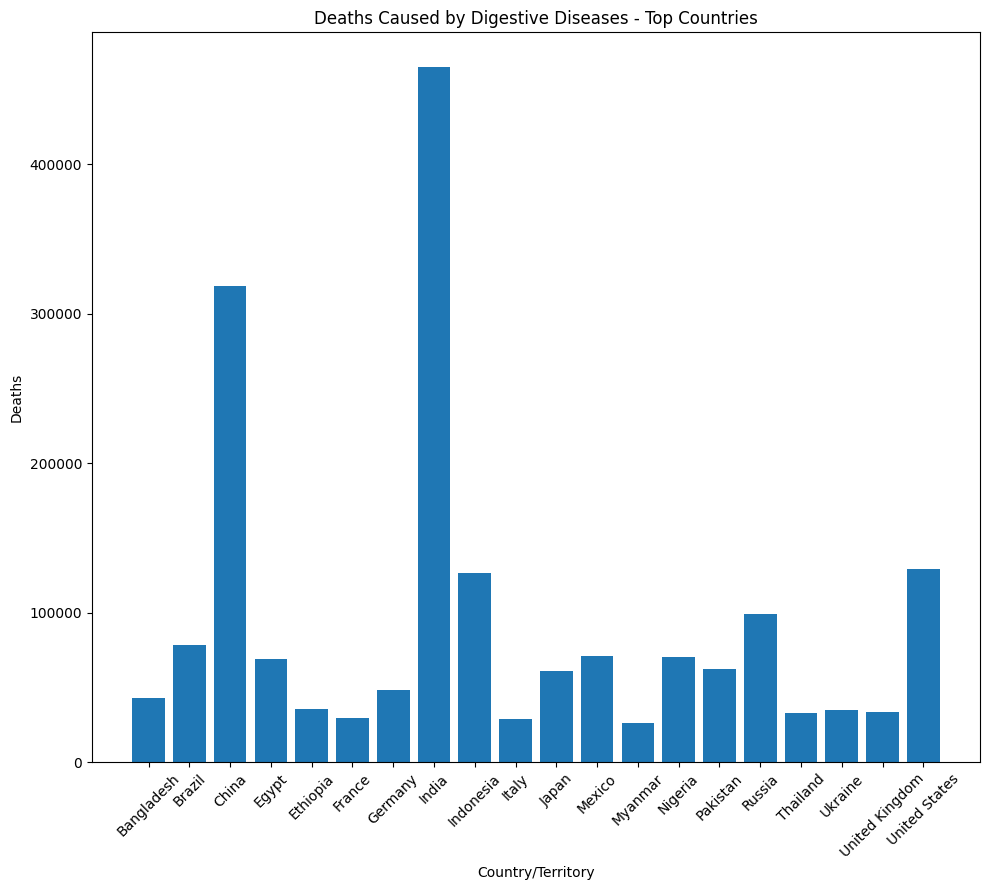

In [34]:
data = df
#grouping by region and summing Digestive Diseases deaths....
region_df = data.groupby('Region')['(n) Digestive Diseases'].sum()

#identifying the top countries...
top_countries = data.groupby('Country/Territory')['(n) Digestive Diseases'].sum().nlargest(20).index

#filtering the DataFrame for top countries...
filtered_df = data[data['Country/Territory'].isin(top_countries)]

#Bar chart for deaths caused by Digestive Diseases in top countries...
plt.figure(figsize=(10, 9))
plt.bar(filtered_df['Country/Territory'], filtered_df['(n) Digestive Diseases'])
plt.xlabel('Country/Territory')
plt.ylabel('Deaths')
plt.title('Deaths Caused by Digestive Diseases - Top Countries')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()



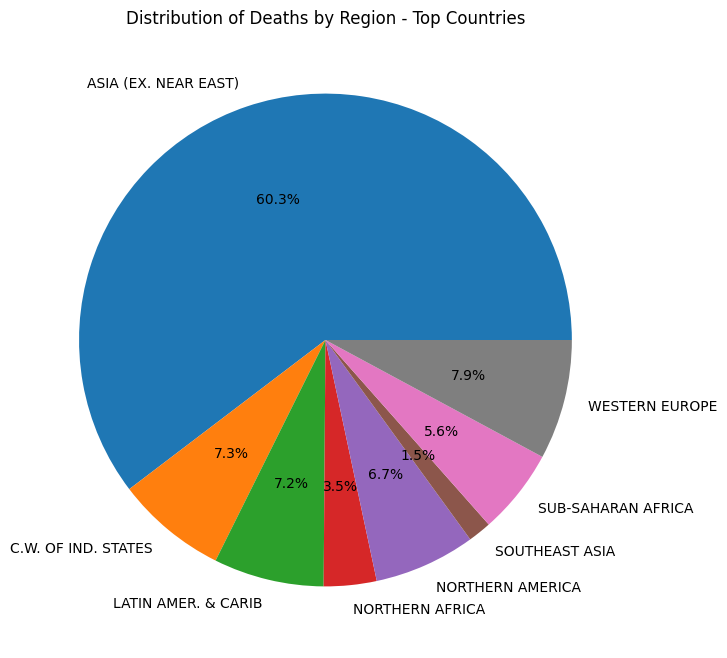

The common region among the top countries is: Asia


In [35]:
#Pie chart showing the distribution of deaths by region in top countries...
plt.figure(figsize=(9, 8))
filtered_df.groupby('Region')['(n) Digestive Diseases'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Deaths by Region - Top Countries')
plt.ylabel('')
plt.show()
# Common region among the top countries
print("The common region among the top countries is: Asia")


C:\Users\Moustafa\AppData\Local\Temp\ipykernel_18780\4210352649.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_chart = sns.barplot(data=average_deaths_subset, x='Pollution', y='(n) Digestive Diseases', palette='viridis')


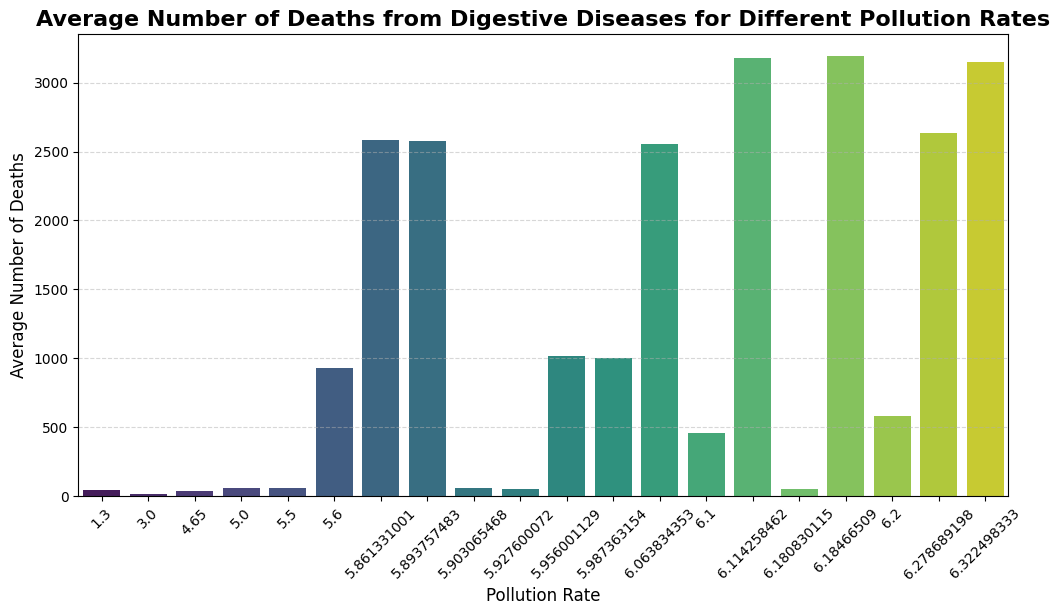

In [36]:
#selecting only the first 20 rows for visualization
average_deaths = data.groupby('Pollution')['(n) Digestive Diseases'].mean().reset_index()
average_deaths_subset = average_deaths.head(20)

# Create a bar chart with adjusted styling
plt.figure(figsize=(12, 6))
bar_chart = sns.barplot(data=average_deaths_subset, x='Pollution', y='(n) Digestive Diseases', palette='viridis')
plt.title('Average Number of Deaths from Digestive Diseases for Different Pollution Rates', fontweight='bold', fontsize=16)
plt.xlabel('Pollution Rate', fontsize=12)
plt.ylabel('Average Number of Deaths', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [37]:
# Description of the relationship
print("The x-axis represents the pollution rates, which have been limited to the first 20 values for better readability.")
print("The y-axis represents the average number of deaths from digestive diseases.")
print("Each bar in the chart corresponds to a specific pollution rate and shows the average number of deaths associated with that rate.")


#Choropleth map for deaths caused by Digestive Diseases in top countries...
fig = px.choropleth(filtered_df, locations='Country/Territory', locationmode='country names',
                    color='(n) Digestive Diseases', hover_name='Country/Territory', projection='natural earth')
fig.update_layout(title='Deaths Caused by Digestive Diseases - Top Countries', coloraxis_colorbar=dict(title='Deaths'))
fig.show()


The x-axis represents the pollution rates, which have been limited to the first 20 values for better readability.
The y-axis represents the average number of deaths from digestive diseases.
Each bar in the chart corresponds to a specific pollution rate and shows the average number of deaths associated with that rate.


Pollution Barchart:
The graph shows the relationship between pollution rates and the average number of deaths from digestive diseases. It shows a positive correlation, meaning that as pollution rates increase, the average number of deaths from digestive diseases also tends to increase. This indicates that higher pollution levels might be associated with higher mortality rates due to these diseases. 
And by analyzing the Pollution and death numbers bar chart, we can identify a potential trends or patterns in the data. For example, we can assess whether there is a correlation between higher pollution rates and an increased average number of deaths from digestive diseases. Additionally, we can observe any outliers or significant variations in the average number of deaths across different pollution rates. But, there are other factors could influence digestive disease rates.

# Question 5

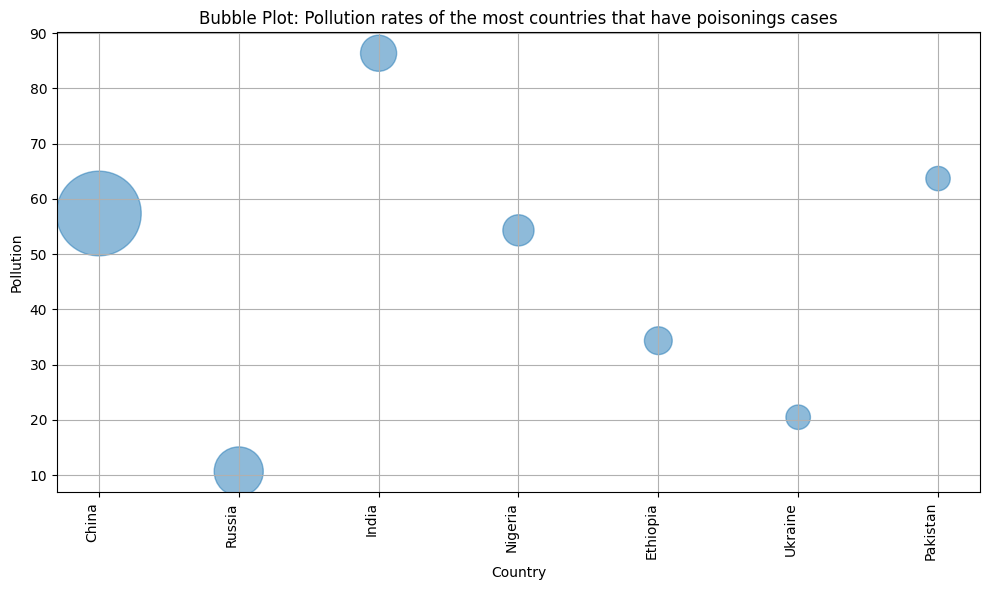

In [38]:
# Which countries have the highest pollution rates, and is there a direct
# relationship between pollution levels and the incidence of poisoning cases in these countries?

# Group by 'Country/Territory' and the sum of poisonings
countries_poisonings = df.groupby('Country/Territory')['(o) Poisonings'].sum()

# Sort it and select the top 7
top_7_countries_poisonings = countries_poisonings.sort_values(ascending=False).head(7)

# DataFrame containing only the top 7 countries and their sum of Poisonings cases
top_7_countries_df = pd.DataFrame({'Country/Territory': top_7_countries_poisonings.index, 'Poisonings Sum': top_7_countries_poisonings.values})

# filter to have the top countries for the previous DataFrame
filtered_df = df[df['Country/Territory'].isin(top_7_countries_poisonings.index)]

# Group by 'Country/Territory' and the mean of polluion
countries_pollution_mean = filtered_df.groupby('Country/Territory')['Pollution'].mean()

# DataFrame containing the mean pollution rates for the top 7 countries
top_7_countries_pollution_mean = pd.DataFrame({'Country/Territory': countries_pollution_mean.index, 'Pollution Mean': countries_pollution_mean.values})

# Merge the two DataFrames
top_countries_df = pd.merge(top_7_countries_df, top_7_countries_pollution_mean, on='Country/Territory')



#Question 6 visualization
countries = top_countries_df['Country/Territory']
deaths = top_countries_df['Poisonings Sum']
pollution=top_countries_df['Pollution Mean']


# Generating bubble sizes proportional to the number of deaths
sizes = deaths / 150

plt.figure(figsize=(10, 6))
plt.scatter(countries,pollution , sizes, alpha=0.5)

plt.xlabel('Country')
plt.ylabel('Pollution')
plt.title('Bubble Plot: Pollution rates of the most countries that have poisonings cases')


plt.grid(True)



# Adjusting layout
plt.xticks(rotation=90, ha='right')

# Displaying the plot
plt.tight_layout()
plt.show()

Highest country that suffers from pollution is India, it doesn't related with the numbers of Poisonings cases as shown in the visualization above.
from another point of view Russia is from the countries that has the lowest pollution rates and has a average number of Poisonings cases
in conclusion pollution rates are not directly related with poisoning cases in most of the conditions

# Hypothesis

## Hypothesis 1: Pollution rates do not have any relationship with the prevalence of digestive diseases leading to mortality in the highest regions that suffer from high numbers of death due to digestive diseases.

In [146]:
alpha = 0.05
h1 = df.groupby('Region').agg({'(n) Digestive Diseases': 'sum', 'Pollution' : 'mean'})

In [147]:
aH1 = h1.nlargest(5,'(n) Digestive Diseases')
bH1 = h1.nsmallest(5, '(n) Digestive Diseases')
x1 = aH1['Pollution']
x2 = bH1['Pollution']

l1 = len(x1)
l2 = len(x2)

l1, l2

(5, 5)

In [155]:
aH1.head()

(n) Digestive Diseases  Pollution
Region                                                 
ASIA (EX. NEAR EAST)                22448011  35.518714
SUB-SAHARAN AFRICA                   5672010  35.034349
LATIN AMER. & CARIB                  4210011  19.343330
WESTERN EUROPE                       3772466  11.449826
C.W. OF IND. STATES                  3289738  25.328178

In [157]:
bH1.head()

(n) Digestive Diseases  Pollution
Region                                            
SOUTHERN AFRICA                    6893  17.851571
BALTICS                           73553  11.863295
CENTRAL EUROPE                    93475  18.059635
OCEANIA                          157984  11.647004
SOUTHEAST ASIA                   505002  38.212561

In [148]:
x1Mean = x1.mean()
x2Mean = x2.mean()
x1Mean, x2Mean

(25.334879329068897, 19.526812897374572)

In [149]:
x1var=x1.var(ddof=1)
x2var=x2.var(ddof=1)
x1var,x2var

(106.62090514405487, 118.73427780672489)

In [150]:
num=(l1-1)*x1var+(l2-1)*x2var
dem=l1+l2-2
part1=num/dem
part2=(1/l1)+(1/l2)
S=np.sqrt(part1*part2)
S

6.713496599400044

In [151]:
tScore=(x1Mean-x2Mean)/S
tScore

0.8651328477940045

In [152]:
## Degree of freedom n-k
## n = total for both groups 1 and 2 (35)
## k = number of groups
DegreeF=l1+l2-2
DegreeF

8

In [153]:
scipy.stats.t.ppf(1-0.05, DegreeF)

1.8595480375228421

In [154]:
scipy.stats.ttest_ind(x1, x2).statistic

0.8651328477940045

Since our value is lower than the table value so we aceept hypothesis, which means there is no relationship between pollution rates and death caused by digestive diseases.

## Hypothesis 2: There is no relationship between pollution rates and death caused by respiratory diseases in the top regions affected by respiratory diseases.

In [184]:
h2 = df.groupby('Region').agg({
    '(n) Lower Respiratory Infections': 'sum',
    '(c) Chronic Respiratory Diseases': 'sum',
    'Pollution': 'mean'})


In [185]:
h2['Respiratory Diseases'] = h2['(n) Lower Respiratory Infections'] + h2['(c) Chronic Respiratory Diseases']
aH2 = h2.nlargest(5,'Respiratory Diseases')
bH2 = h2.nsmallest(5, 'Respiratory Diseases')
x1 = aH2['Pollution']
x2 = bH2['Pollution']

l1 = len(x1)
l2 = len(x2)

l1, l2

(5, 5)

In [186]:
aH2.head()

(n) Lower Respiratory Infections  \
Region                                                   
ASIA (EX. NEAR EAST)                          23670997   
SUB-SAHARAN AFRICA                            15476404   
LATIN AMER. & CARIB                            3945549   
WESTERN EUROPE                                 2742157   
NORTHERN AMERICA                               1609792   

                      (c) Chronic Respiratory Diseases  Pollution  \
Region                                                              
ASIA (EX. NEAR EAST)                          50945058  35.518714   
SUB-SAHARAN AFRICA                             3289719  35.034349   
LATIN AMER. & CARIB                            3323934  19.343330   
WESTERN EUROPE                                 4191470  11.449826   
NORTHERN AMERICA                               3985303   9.987633   

                      Respiratory Diseases  
Region                                      
ASIA (EX. NEAR EAST)              74616055  
SUB-SAHARAN AFRICA                18766123  
LATIN AMER. & CARIB                7269483  
WESTERN EUROPE                     6933627  
NORTHERN AMERICA                   5595095

In [187]:
bH2.head()

(n) Lower Respiratory Infections  \
Region                                              
SOUTHERN AFRICA                             17909   
BALTICS                                     24902   
CENTRAL EUROPE                              58184   
OCEANIA                                    219075   
EASTERN EUROPE                             495762   

                 (c) Chronic Respiratory Diseases  Pollution  \
Region                                                         
SOUTHERN AFRICA                              6652  17.851571   
BALTICS                                     33408  11.863295   
CENTRAL EUROPE                              63267  18.059635   
OCEANIA                                    353349  11.647004   
EASTERN EUROPE                             751818  22.170489   

                 Respiratory Diseases  
Region                                 
SOUTHERN AFRICA                 24561  
BALTICS                         58310  
CENTRAL EUROPE                 121451  
OCEANIA                        572424  
EASTERN EUROPE                1247580

In [188]:
x1Mean = x1.mean()
x2Mean = x2.mean()
x1Mean, x2Mean

(22.266770343073063, 16.318398584924573)

In [189]:
x1var=x1.var(ddof=1)
x2var=x2.var(ddof=1)
x1var,x2var

(153.73877240375478, 20.324839634518437)

In [190]:
num=(l1-1)*x1var+(l2-1)*x2var
dem=l1+l2-2
part1=num/dem
part2=(1/l1)+(1/l2)
S=np.sqrt(part1*part2)
S

5.900230708002412

In [191]:
tScore=(x1Mean-x2Mean)/S
tScore

1.008159180975887

In [192]:
## Degree of freedom n-k
## n = total for both groups 1 and 2 (35)
## k = number of groups
DegreeF=l1+l2-2
DegreeF

8

In [193]:
scipy.stats.t.ppf(1-0.05, DegreeF)

1.8595480375228421

In [194]:
scipy.stats.ttest_ind(x1, x2).statistic

1.008159180975887

We accpet the hypothesis as there is no relationship between death caused by respiratory diseases and pollution rates as t Score < table value

## Hypothesis 3:  There is no relationship between countries which has the highest levels of pollution and the number of deaths by poisoning

In [174]:
h3 = df.groupby('Country/Territory').agg({
    '(o) Poisonings': 'sum',
    'Pollution': 'mean'})

In [219]:
aH3 = h3.nlargest(10,'Pollution')
bH3 = h3.nsmallest(10, 'Pollution')
x1 = aH3['(o) Poisonings']
x2 = bH3['(o) Poisonings']

l1 = len(x1)
l2 = len(x2)

l1, l2

(10, 10)

In [220]:
aH3.head()

(o) Poisonings  Pollution
Country/Territory                           
Nepal                       11173  88.458564
India                      101375  86.340289
Qatar                         100  77.951323
Niger                        8574  75.911779
Saudi Arabia                 4000  73.071446

In [221]:
bH3.head()

(o) Poisonings  Pollution
Country/Territory                           
Finland                       265   6.384142
Brunei                         20   6.694897
Sweden                        627   6.724071
Iceland                        20   6.792922
New Zealand                   168   6.802298

In [222]:
x1Mean = x1.mean()
x2Mean = x2.mean()
x1Mean, x2Mean

(19513.9, 3327.1)

In [223]:
x1var=x1.var(ddof=1)
x2var=x2.var(ddof=1)
x1var,x2var

(1001185086.7666669, 78422136.9888889)

In [224]:
num=(l1-1)*x1var+(l2-1)*x2var
dem=l1+l2-2
part1=num/dem
part2=(1/l1)+(1/l2)
S=np.sqrt(part1*part2)
S

tScore=(x1Mean-x2Mean)/S
tScore

## Degree of freedom n-k
## n = total for both groups 1 and 2 (35)
## k = number of groups
DegreeF=l1+l2-2
DegreeF

18

In [225]:
scipy.stats.t.ppf(1-0.05, DegreeF)

1.7340636066175354

In [226]:
scipy.stats.ttest_ind(x1, x2).statistic

1.5578588643667792

There is no relationship between pollution and death incidents that is caused by poisonings as t Score < table value